In [ ]:
import pandas as pd
import glob
import os

def load_and_consolidate_data(data_directory):
    """
    Loads all daily .pkl transaction files from a directory, consolidates them
    into a single DataFrame, and performs initial cleanup.
    """
    file_pattern = os.path.join(data_directory, '*.pkl')
    pkl_files = glob.glob(file_pattern)
    
    if not pkl_files:
        print(f"No .pkl files found in the directory: {data_directory}")
        return None
    
    print(f"Found {len(pkl_files)} daily transaction files. Loading...")
    
    daily_dataframes = []
    for file in pkl_files:
        try:
            df_daily = pd.read_pickle(file)
            daily_dataframes.append(df_daily)
        except Exception as e:
            print(f"Could not read file {file}: {e}")
            
    print("Consolidating all files into a single DataFrame...")
    df_transactions = pd.concat(daily_dataframes, ignore_index=True)
    
   
    print("Converting the datetime column...")
    correct_datetime_column = 'TX_DATETIME' 
    df_transactions[correct_datetime_column] = pd.to_datetime(df_transactions[correct_datetime_column])
    
    
    print("Sorting transactions by date and time...")
    df_transactions = df_transactions.sort_values(by=correct_datetime_column).reset_index(drop=True)
    
    print("\nData loading and consolidation complete!")
    return df_transactions


DATA_PATH = '/Users/chandu/MachineLearning_Project/Unified_mentor(internship)/Projects/My_List/fraud_detection/data'

# Call the function to load the data
transactions_df = load_and_consolidate_data(DATA_PATH)

# Display the results to verify
if transactions_df is not None:
    print("\n--- First 5 rows of the consolidated data ---")
    print(transactions_df.head())
    
    print("\n--- Dataframe Information ---")
    transactions_df.info()

Found 183 daily transaction files. Loading...


--- Transaction Class Distribution ---
TX_FRAUD
0    99.163073
1     0.836927
Name: proportion, dtype: float64




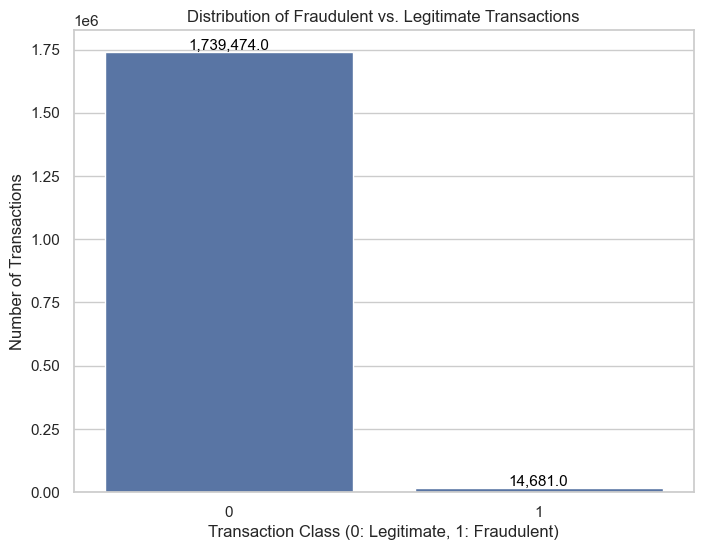

In [7]:
# Exploratory Data Analysis:


# Check for Class Imbalance
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# --- Check Class Distribution ---
print("--- Transaction Class Distribution ---")
fraud_distribution = transactions_df['TX_FRAUD'].value_counts(normalize=True) * 100
print(fraud_distribution)
print("\n")

# --- Visualize the Distribution ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='TX_FRAUD', data=transactions_df)
plt.title('Distribution of Fraudulent vs. Legitimate Transactions')
plt.xlabel('Transaction Class (0: Legitimate, 1: Fraudulent)')
plt.ylabel('Number of Transactions')

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

--- Summary Statistics for Transaction Amount ---
              count        mean         std   min    25%    50%     75%  \
TX_FRAUD                                                                  
0         1739474.0   52.977907   39.421733  0.00  20.94  44.49   76.63   
1           14681.0  131.168024  154.485795  0.02  32.98  72.22  177.30   

              max  
TX_FRAUD           
0          219.98  
1         2628.00  


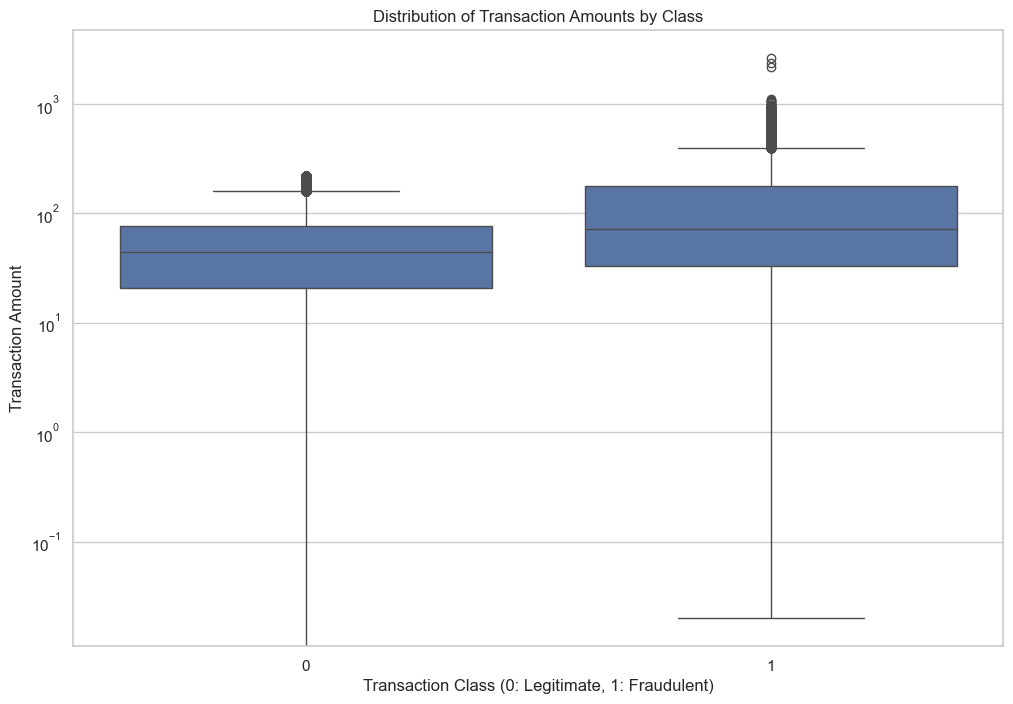

In [8]:
# Analyze Transaction Amounts
print("--- Summary Statistics for Transaction Amount ---")
# Get summary statistics for transaction amounts grouped by class
amount_stats = transactions_df.groupby('TX_FRAUD')['TX_AMOUNT'].describe()
print(amount_stats)

# --- Visualize the Amount Distributions ---
plt.figure(figsize=(12, 8))
sns.boxplot(x='TX_FRAUD', y='TX_AMOUNT', data=transactions_df)
plt.title('Distribution of Transaction Amounts by Class')
plt.xlabel('Transaction Class (0: Legitimate, 1: Fraudulent)')
plt.ylabel('Transaction Amount')
plt.yscale('log') # Use a log scale to better visualize skewed data
plt.show()

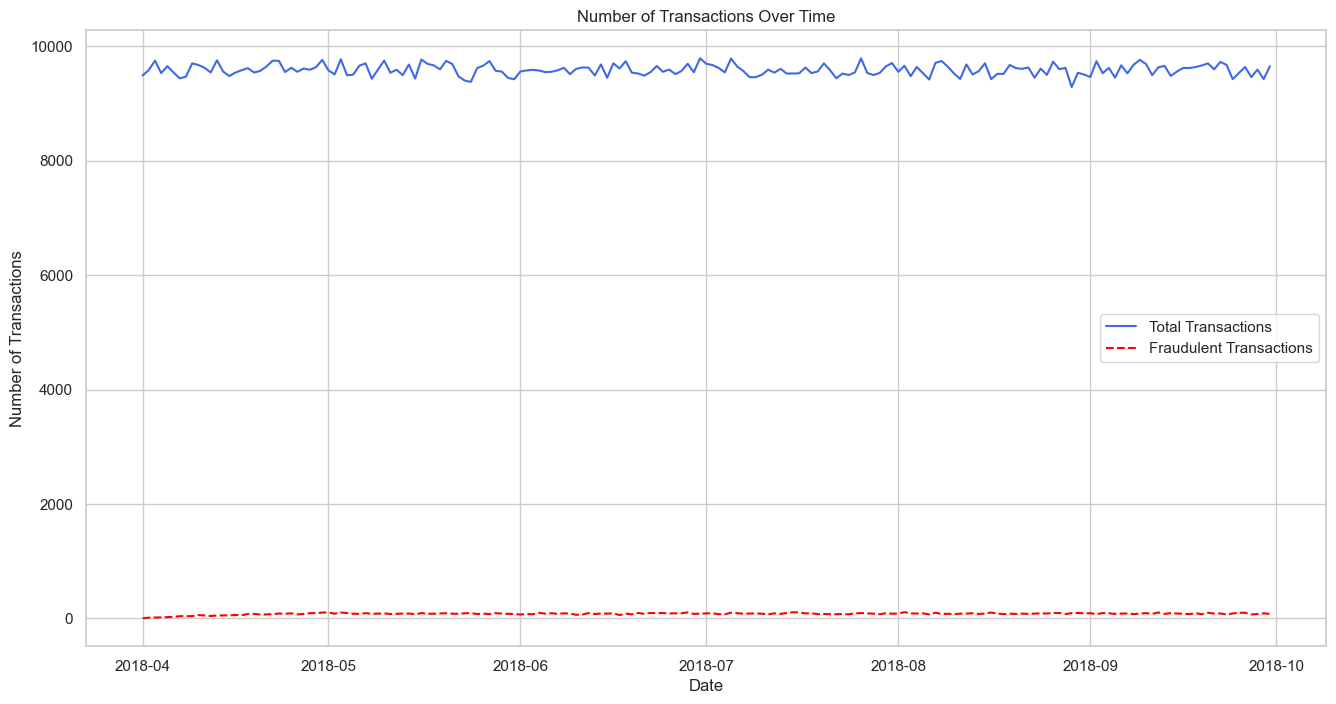

In [9]:
# Visualize Trends Over Time

# Resample data by day to count total transactions and fraudulent transactions
daily_transactions = transactions_df.set_index('TX_DATETIME').resample('D').size()
daily_fraud = transactions_df[transactions_df['TX_FRAUD'] == 1].set_index('TX_DATETIME').resample('D').size()

plt.figure(figsize=(16, 8))

# Plot total transactions
plt.plot(daily_transactions.index, daily_transactions.values, label='Total Transactions', color='royalblue')

# Plot fraudulent transactions
plt.plot(daily_fraud.index, daily_fraud.values, label='Fraudulent Transactions', color='red', linestyle='--')

plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()

In [11]:
# Featuer Engineering

#Time-Based Feature

# Make a copy to keep the original dataframe safe
transactions_df_features = transactions_df.copy()

# Extract hour of the day
transactions_df_features['TX_HOUR'] = transactions_df_features['TX_DATETIME'].dt.hour

# Extract day of the week (Monday=0, Sunday=6)
transactions_df_features['TX_DAY_OF_WEEK'] = transactions_df_features['TX_DATETIME'].dt.dayofweek

print("--- Dataframe with new time-based features ---")
print(transactions_df_features.head())

--- Dataframe with new time-based features ---
   TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0               0 2018-04-01 00:00:31         596        3156      57.16   
1               1 2018-04-01 00:02:10        4961        3412      81.51   
2               2 2018-04-01 00:07:56           2        1365     146.00   
3               3 2018-04-01 00:09:29        4128        8737      64.49   
4               4 2018-04-01 00:10:34         927        9906      50.99   

  TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  TX_HOUR  \
0              31            0         0                  0        0   
1             130            0         0                  0        0   
2             476            0         0                  0        0   
3             569            0         0                  0        0   
4             634            0         0                  0        0   

   TX_DAY_OF_WEEK  
0               6  
1               6  
2  

In [12]:
# Customer-Centric Aggregate Features

import pandas as pd

# Set the transaction datetime as the index for time-based rolling calculations
df_indexed = transactions_df_features.set_index('TX_DATETIME')

# --- CORRECTED AGGREGATION LOGIC ---
print("Calculating customer-centric features... ")

# 1. Group by customer and create a rolling window object
customer_rolling_obj = df_indexed.groupby('CUSTOMER_ID').rolling(window='5min', min_periods=1)

# 2. Define the aggregations using a dictionary (older, compatible syntax)
aggregations = {
    'TRANSACTION_ID': 'count',
    'TX_AMOUNT': 'mean'
}
customer_aggregates = customer_rolling_obj.agg(aggregations)

# 3. Rename the columns to our desired names
customer_aggregates.rename(columns={
    'TRANSACTION_ID': 'TX_COUNT_5MIN_CUSTOMER',
    'TX_AMOUNT': 'TX_AMOUNT_MEAN_5MIN_CUSTOMER'
}, inplace=True)

# 4. Reset the index to turn 'CUSTOMER_ID' and 'TX_DATETIME' back into columns
customer_aggregates = customer_aggregates.reset_index()

# 5. Merge the new features back into the main dataframe
transactions_df_features = pd.merge(
    transactions_df_features,
    customer_aggregates,
    on=['CUSTOMER_ID', 'TX_DATETIME'],
    how='left'
)

print("\n--- Dataframe with new customer-centric features ---")
print(transactions_df_features.head())

Calculating customer-centric features... 

--- Dataframe with new customer-centric features ---
   TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0               0 2018-04-01 00:00:31         596        3156      57.16   
1               1 2018-04-01 00:02:10        4961        3412      81.51   
2               2 2018-04-01 00:07:56           2        1365     146.00   
3               3 2018-04-01 00:09:29        4128        8737      64.49   
4               4 2018-04-01 00:10:34         927        9906      50.99   

  TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  TX_HOUR  \
0              31            0         0                  0        0   
1             130            0         0                  0        0   
2             476            0         0                  0        0   
3             569            0         0                  0        0   
4             634            0         0                  0        0   

   TX_DAY_OF_W

In [13]:
# Terminal-Centric Aggregate Features

import pandas as pd


transactions_df_features = transactions_df.copy()


transactions_df_features['TX_HOUR'] = transactions_df_features['TX_DATETIME'].dt.hour
transactions_df_features['TX_DAY_OF_WEEK'] = transactions_df_features['TX_DATETIME'].dt.dayofweek

print("--- Dataframe with new time-based features ---")
print(transactions_df_features.head())


df_indexed = transactions_df_features.set_index('TX_DATETIME')
print("\nCalculating customer-centric features... ")

customer_rolling_obj = df_indexed.groupby('CUSTOMER_ID').rolling(window='5min', min_periods=1)
aggregations_customer = {'TRANSACTION_ID': 'count', 'TX_AMOUNT': 'mean'}
customer_aggregates = customer_rolling_obj.agg(aggregations_customer)
customer_aggregates.rename(columns={'TRANSACTION_ID': 'TX_COUNT_5MIN_CUSTOMER', 'TX_AMOUNT': 'TX_AMOUNT_MEAN_5MIN_CUSTOMER'}, inplace=True)
customer_aggregates = customer_aggregates.reset_index()

transactions_df_features = pd.merge(transactions_df_features, customer_aggregates, on=['CUSTOMER_ID', 'TX_DATETIME'], how='left')

print("\n--- Dataframe with new customer-centric features ---")
print(transactions_df_features.head())


print("\nCalculating terminal-centric features... ")

terminal_rolling_obj = df_indexed.groupby('TERMINAL_ID').rolling(window='5min', min_periods=1)
aggregations_terminal = {'TRANSACTION_ID': 'count', 'TX_FRAUD': 'sum'}
terminal_aggregates = terminal_rolling_obj.agg(aggregations_terminal)
terminal_aggregates.rename(columns={'TRANSACTION_ID': 'TX_COUNT_5MIN_TERMINAL', 'TX_FRAUD': 'TX_FRAUD_COUNT_5MIN_TERMINAL'}, inplace=True)
terminal_aggregates = terminal_aggregates.reset_index()

transactions_df_features = pd.merge(transactions_df_features, terminal_aggregates, on=['TERMINAL_ID', 'TX_DATETIME'], how='left')

print("\n--- Final Dataframe with all new features ---")
print(transactions_df_features.head())

print("\n--- Missing values check ---")
print(transactions_df_features.isnull().sum())

--- Dataframe with new time-based features ---
   TRANSACTION_ID         TX_DATETIME CUSTOMER_ID TERMINAL_ID  TX_AMOUNT  \
0               0 2018-04-01 00:00:31         596        3156      57.16   
1               1 2018-04-01 00:02:10        4961        3412      81.51   
2               2 2018-04-01 00:07:56           2        1365     146.00   
3               3 2018-04-01 00:09:29        4128        8737      64.49   
4               4 2018-04-01 00:10:34         927        9906      50.99   

  TX_TIME_SECONDS TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  TX_HOUR  \
0              31            0         0                  0        0   
1             130            0         0                  0        0   
2             476            0         0                  0        0   
3             569            0         0                  0        0   
4             634            0         0                  0        0   

   TX_DAY_OF_WEEK  
0               6  
1               6  
2  

In [20]:
import lightgbm as lgb
import pandas as pd


y = transactions_df_features['TX_FRAUD']
X = transactions_df_features.drop(
    columns=[
        'TX_FRAUD', 
        'TRANSACTION_ID', 
        'CUSTOMER_ID', 
        'TERMINAL_ID', 
        'TX_DATETIME',
        'TX_FRAUD_SCENARIO'
    ]
)


# Convert any 'object' type columns to numeric.
# This handles columns like 'TX_TIME_SECONDS' which might not be numbers yet.
print("Checking for and converting non-numeric columns...")
for col in X.columns:
    if X[col].dtype == 'object':
        print(f"Converting column '{col}' to numeric...")
        X[col] = pd.to_numeric(X[col], errors='coerce')


# Fill any missing values that might exist or were created during conversion
X.fillna(0, inplace=True)

print("\n--- Feature Matrix (X) after preparation ---")
X.info()


split_index = int(len(X) * 0.80)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"\nTraining set size: {len(X_train)} transactions")
print(f"Test set size: {len(X_test)} transactions")




scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

print("\nTraining the LightGBM model")
model = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1  # <- Add this line to hide the warnings
)

model.fit(X_train, y_train)

print("Model training complete!")

Checking for and converting non-numeric columns...
Converting column 'TX_TIME_SECONDS' to numeric...
Converting column 'TX_TIME_DAYS' to numeric...

--- Feature Matrix (X) after preparation ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754237 entries, 0 to 1754236
Data columns (total 9 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   TX_AMOUNT                     float64
 1   TX_TIME_SECONDS               int64  
 2   TX_TIME_DAYS                  int64  
 3   TX_HOUR                       int32  
 4   TX_DAY_OF_WEEK                int32  
 5   TX_COUNT_5MIN_CUSTOMER        float64
 6   TX_AMOUNT_MEAN_5MIN_CUSTOMER  float64
 7   TX_COUNT_5MIN_TERMINAL        float64
 8   TX_FRAUD_COUNT_5MIN_TERMINAL  float64
dtypes: float64(5), int32(2), int64(2)
memory usage: 107.1 MB

Training set size: 1403389 transactions
Test set size: 350848 transactions
Scale Pos Weight: 120.70

Training the LightGBM model
Model training complete!


--- Classification Report ---
                precision    recall  f1-score   support

Legitimate (0)       1.00      1.00      1.00    347698
     Fraud (1)       1.00      1.00      1.00      3150

      accuracy                           1.00    350848
     macro avg       1.00      1.00      1.00    350848
  weighted avg       1.00      1.00      1.00    350848



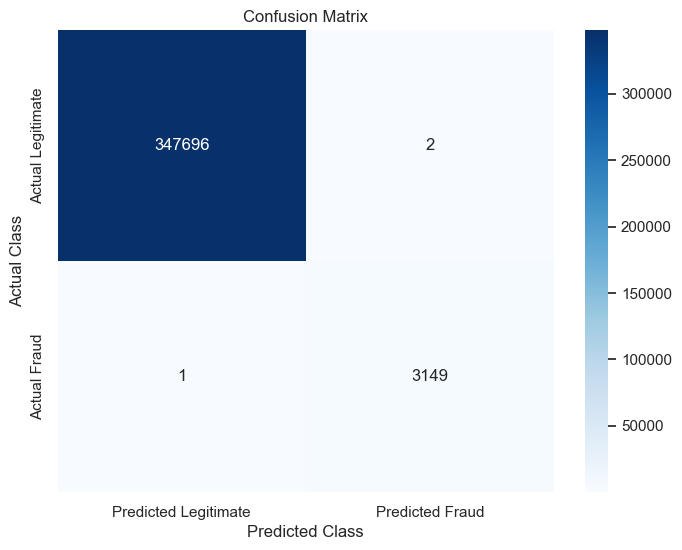

In [21]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Get prediction probabilities for the positive class (fraud)
y_pred_proba = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report

print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Fraud (1)']))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize it as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Legitimate', 'Predicted Fraud'], 
            yticklabels=['Actual Legitimate', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

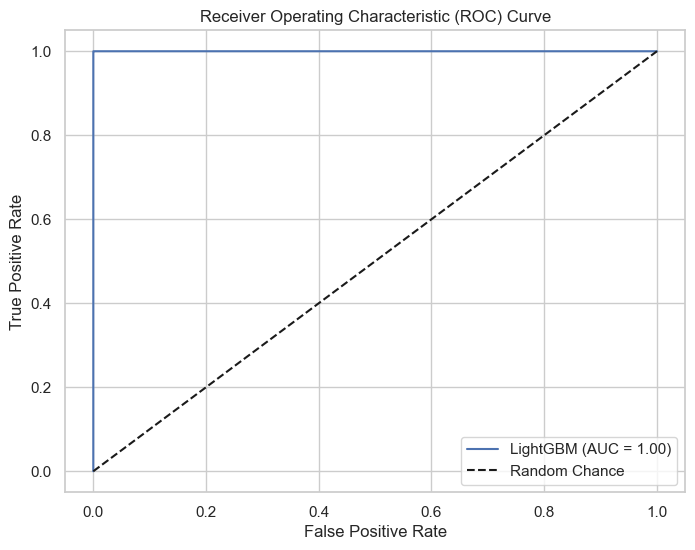

The AUC Score is: 1.0000


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

print(f"The AUC Score is: {auc_score:.4f}")